# Análise de faixa renda utilizando base IBGE  

- Construção de um modelo que tem como objetivo fazer uma estimativa de faixa de renda para clientes sem esta informação. Para estes clientes sem renda, o modelo visa classificá-lo em uma faixa de renda por meio do cruzamento de informações do SICLI com a base do IBGE possibilitando, dessa forma, o pareamento dos clientes sem renda informada em uma **faixa de renda estimada**.
- O código é aplicado tendo como entrada a base cadastral pré-processada e enriquecida com áreas de ponderação e informações do IBGE. São testados diversos modelos de _Machine Learning_ para se chegar em uma escolha ótima de modelo. Após selecionado o modelo é treinado utilizando a base de dados. Por fim ele apresenta uma avaliação de suas métricas: precision, recall, f1-score e acurácia, além de outras métricas de efetividade geral.
- Estas fases estão explicadas em detalhe ao longo do código, bem como seu funcionamento.

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
from IPython.display import Image
%matplotlib inline
pd.set_option('display.max_columns', None)

In [3]:
# Ler o arquivo
dataset = pd.read_csv("/home/marcello/Documentos/git/ibge-indicadores-censitarios/dados/notebook/pre_processing_cliente_renda_ibge/pre_processing_cliente_renda_ibge.csv", sep=';')
dataset.shape

(1741828, 23)

- Histórico de Salário Mínimo - IPAE
- http://www.ipeadata.gov.br/ExibeSerie.aspx?stub=1&serid1739471028=1739471028

In [4]:
# Definição das features (inputs) e label (target)
features = ["nu_estdo_civil_p27","idade","ic_sexo", # "nu_cep_full", # SICLI
            "co_area_ponderacao", # IBGE
            "pc_idade_area_ponderacao", # IBGE
            "pc_total_pessoa_area_ponderacao_liquida"] # IBGE
            #"vr_salario_minimo", # domínio IPEA
            #"pc_idade_area_ponderacao","nu_total_pessoa_area_ponderacao_liquida", # IBGE
            #"pc_total_pessoa_area_ponderacao_liquida"] # IBGE
            
features_comparar = ["nu_estdo_civil_p27","idade","ic_sexo", "co_area_ponderacao", 
                     "pc_idade_area_ponderacao", "pc_total_pessoa_area_ponderacao_liquida", 
                     "nu_estdo_civil_p27", "dt_apuracao_renda", 
                     "vr_salario_minimo", "vr_renda_bruta", "vr_renda_liquida", 
                     "faixa_renda_bruta", 'faixa_renda_estimada']

label = ['faixa_renda_bruta'] # RENDA BRUTA / SALÁRIO MÍNIMO na DT_APURACAO (São 8 faixas: 0 à 7)

dataset # TODAS AS VARIÁVEIS DO DATASET LISTADAS 

,nu_pessoa,nu_cep_full,co_area_ponderacao,idade,ic_tipo_renda,ic_sexo,nu_estdo_civil_p27,de_estado_civil,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,qt_salario_minimo_renda_bruta,faixa_renda_bruta,de_faixa_renda_bruta,vr_renda_liquida,qt_salario_minimo_renda_liquida,faixa_renda_liquida,de_faixa_renda_liquida,pc_idade_area_ponderacao,nu_total_pessoa_area_ponderacao_bruta,pc_total_pessoa_area_ponderacao_bruta,nu_total_pessoa_area_ponderacao_liquida,pc_total_pessoa_area_ponderacao_liquida
0,6040167898604,35700529,3167202005001,41,?,M,7,6,202007,1045.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,1.79,215.0,2.63,215.0,2.63
1,4660020081466,35240000,3118403001001,72,?,F,5,2,202007,1045.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,8.06,720.0,8.44,720.0,8.44
2,5970009130597,37470000,3163706003002,33,?,F,0,0,202007,1045.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,2.11,370.0,3.85,370.0,3.85
3,5460178698546,36878000,3156452001001,20,I,M,1,7,201709,937.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,1.44,119.0,6.06,119.0,6.06
4,9130086953913,37262000,3159902001001,24,I,M,1,5,201404,724.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,2.00,113.0,1.46,113.0,1.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741823,6140096309614,30535610,3106200005044,75,I,M,9,9,200607,350.0,0.0,0.0,0,Sem rendimento,1000.0,2.857143,3,Mais de 2 a 3 salários mínimos,8.68,325.0,1.88,1931.0,11.19
1741824,8900116294890,39500000,3142908001001,44,?,F,0,0,202007,1045.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,1.90,1885.0,19.78,1885.0,19.78
1741825,4370062327437,33937070,3154606005019,52,?,M,0,0,202007,1045.0,0.0,0.0,0,Sem rendimento,0.0,0.000000,0,Sem rendimento,1.09,73.0,1.02,73.0,1.02
1741826,4200022084420,37165000,3111309001001,49,I,F,1,0,200409,260.0,0.0,0.0,0,Sem rendimento,800.0,3.076923,4,Mais de 3 a 5 salários mínimos,1.48,262.0,4.74,139.0,2.52


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741828 entries, 0 to 1741827
Data columns (total 23 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   nu_pessoa                                int64  
 1   nu_cep_full                              int64  
 2   co_area_ponderacao                       int64  
 3   idade                                    int64  
 4   ic_tipo_renda                            object 
 5   ic_sexo                                  object 
 6   nu_estdo_civil_p27                       int64  
 7   de_estado_civil                          int64  
 8   dt_apuracao_renda                        int64  
 9   vr_salario_minimo                        float64
 10  vr_renda_bruta                           float64
 11  qt_salario_minimo_renda_bruta            float64
 12  faixa_renda_bruta                        int64  
 13  de_faixa_renda_bruta                     object 
 14  vr_renda_liquida  

### Função que gera os gráficos: histograma, distribuição normal e Boxplot

In [6]:
import scipy.stats as stats
def diagnostic_number_plots(dataset):
    for v in dataset:
        if pd.api.types.is_numeric_dtype(dataset[v]) == True:
            # define figure size
            plt.figure(figsize=(16, 4))

            # histogram
            plt.subplot(1, 3, 1)
            sns.distplot(dataset[v], bins=30)
            plt.title('Histogram')

            # Q-Q plot
            plt.subplot(1, 3, 2)
            stats.probplot(dataset[v], dist="norm", plot=plt)
            plt.ylabel(v+' quantiles')

            # boxplot
            plt.subplot(1, 3, 3)
            sns.boxplot(y=dataset[v])
            plt.title('Boxplot')

            plt.show()

### Gera os gráficos
- Histograma
- Distribuição
- Boxplot

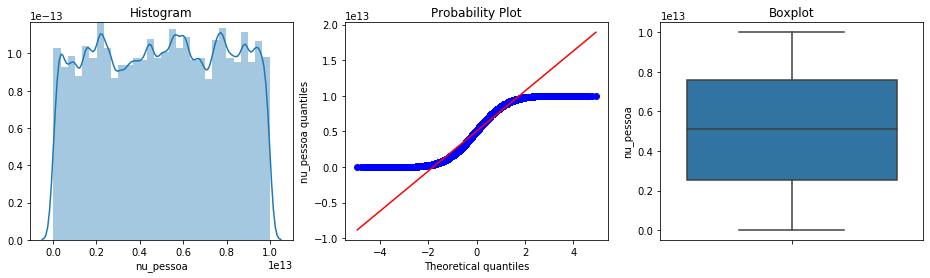

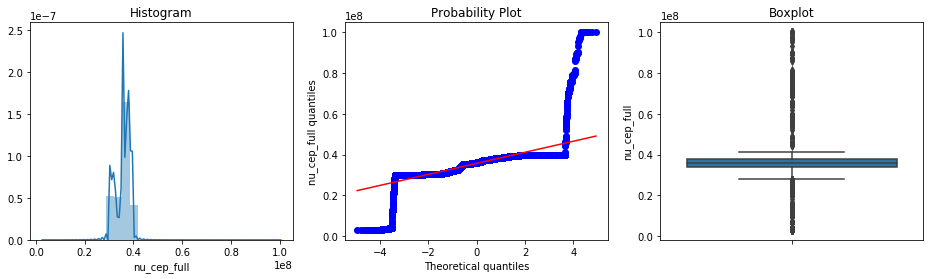

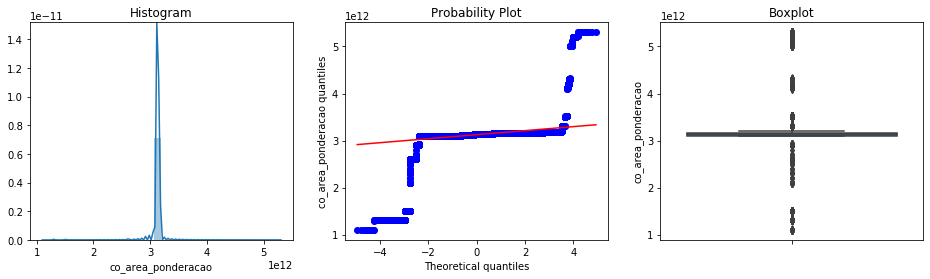

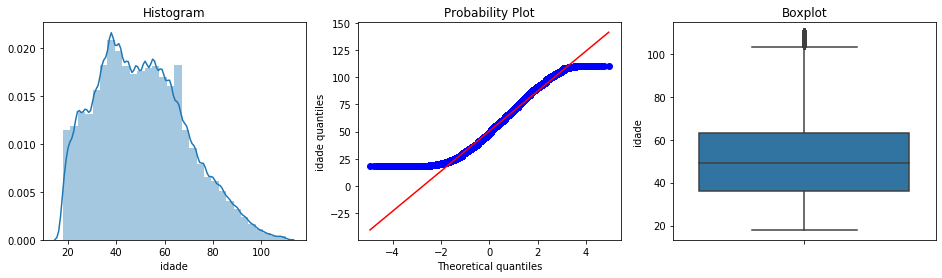

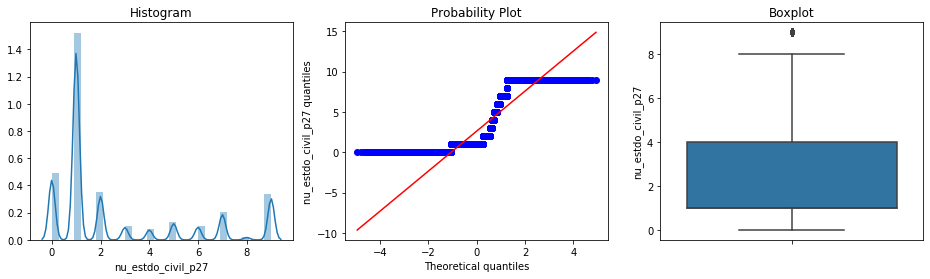

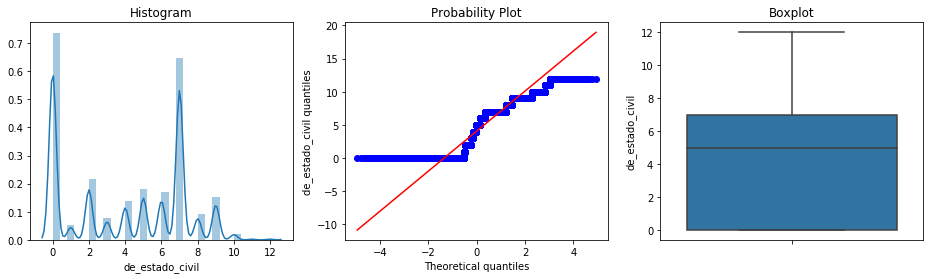

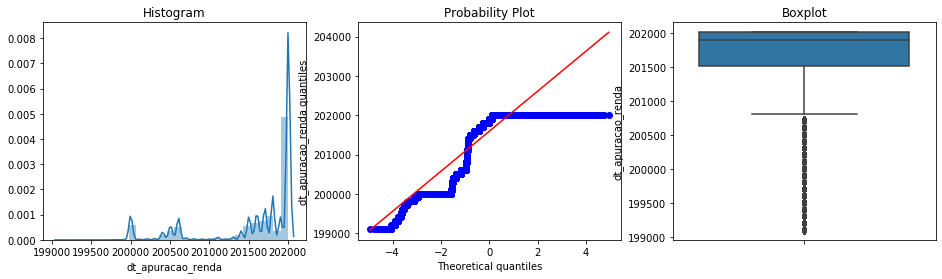

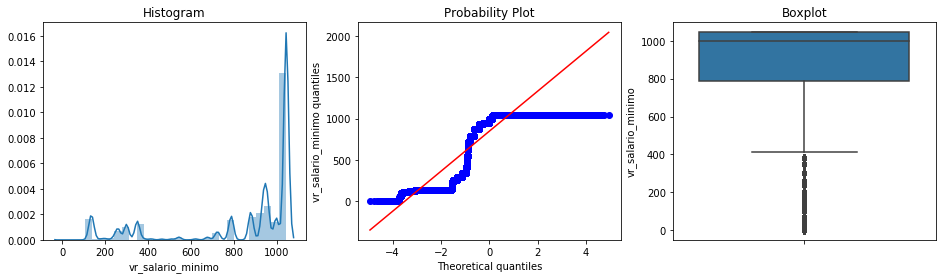

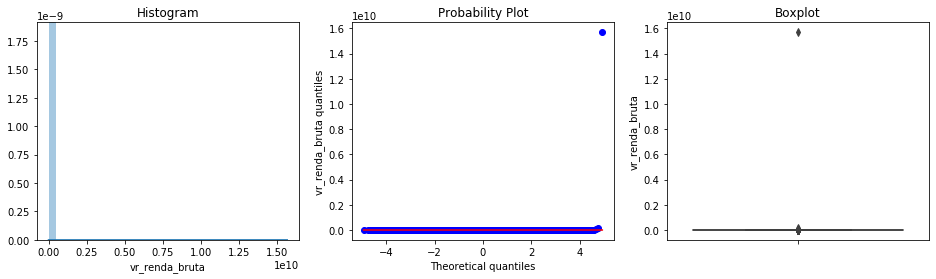

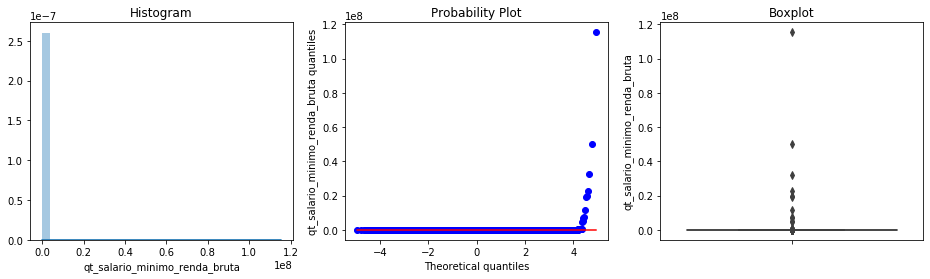

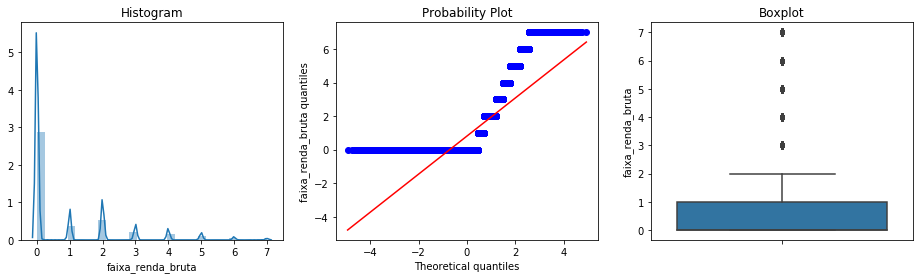

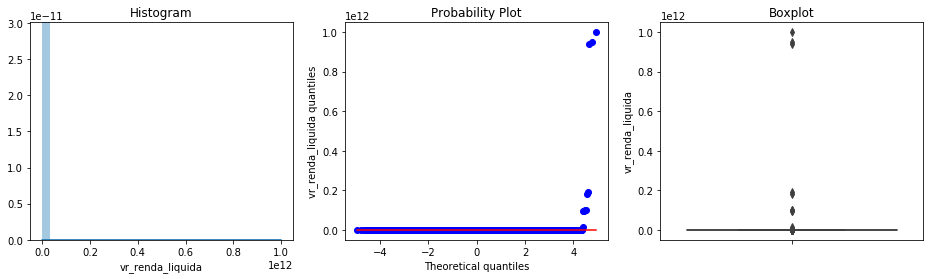

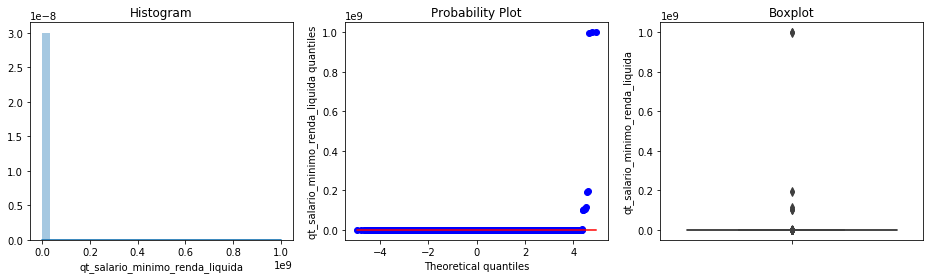

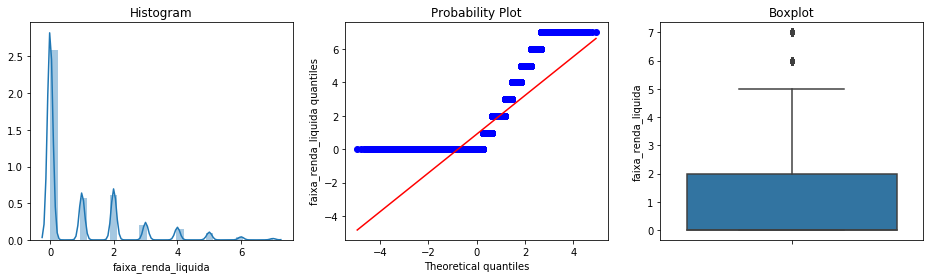

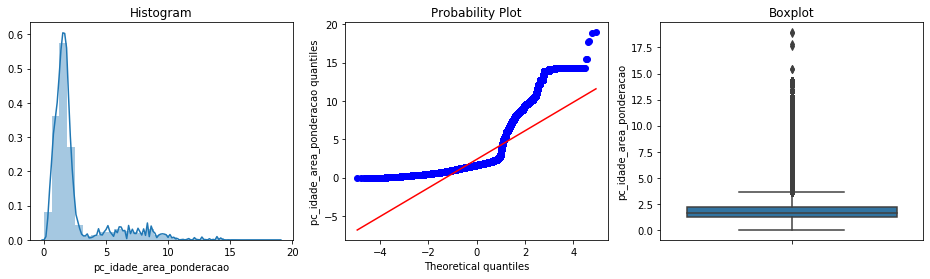

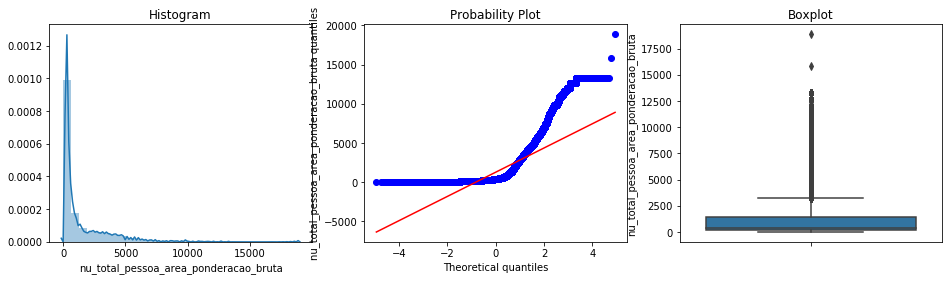

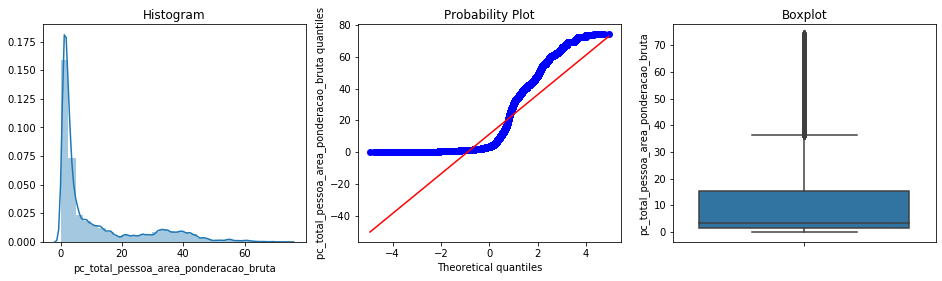

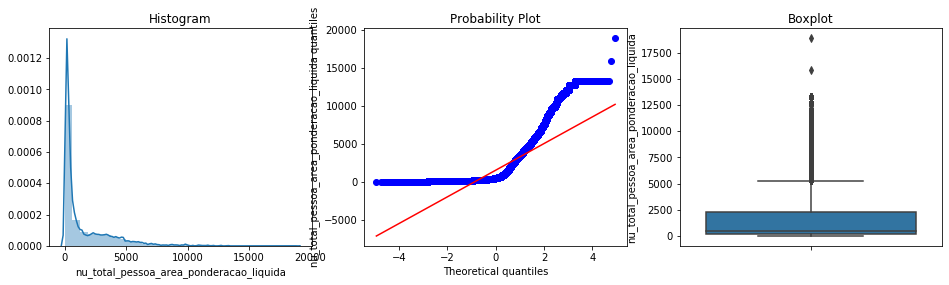

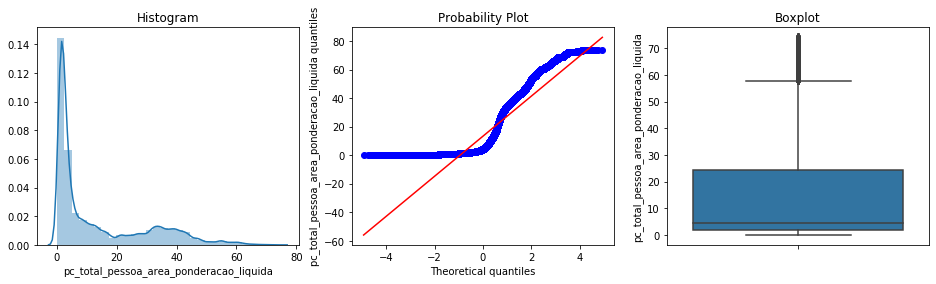

In [7]:
# Executa a função sobre todo o dataset
diagnostic_number_plots(dataset)

### Redefinição de tipos de variáveis visando a redução do tamanho de arquivo do dataset

In [8]:
#mudança de dtypes para reduzir carga de processamento
dataset['idade'] = dataset['idade'].astype('uint8')
dataset['nu_estdo_civil_p27'] = dataset['nu_estdo_civil_p27'].astype('uint8')
dataset['dt_apuracao_renda'] = dataset['dt_apuracao_renda'].astype('uint32')
dataset['vr_salario_minimo'] = dataset['vr_salario_minimo'].astype('float32')
dataset['qt_salario_minimo_renda_bruta'] = dataset['qt_salario_minimo_renda_bruta'].astype('float16')
dataset['faixa_renda_bruta'] = dataset['faixa_renda_bruta'].astype('int8')
dataset['qt_salario_minimo_renda_liquida'] = dataset['qt_salario_minimo_renda_liquida'].astype('float16')
dataset['faixa_renda_bruta'] = dataset['faixa_renda_bruta'].astype('int8')
#dataset['pc_idade_area_ponderacao'] = dataset['pc_idade_area_ponderacao'].astype('float16')
dataset['nu_total_pessoa_area_ponderacao_bruta'] = dataset['nu_total_pessoa_area_ponderacao_bruta'].astype('int32')
#dataset['pc_total_pessoa_area_ponderacao_bruta'] = dataset['pc_total_pessoa_area_ponderacao_bruta'].astype('float16')
dataset['nu_total_pessoa_area_ponderacao_liquida'] = dataset['nu_total_pessoa_area_ponderacao_liquida'].astype('int32')

In [9]:
# Mostra a mudança de vartype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741828 entries, 0 to 1741827
Data columns (total 23 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   nu_pessoa                                int64  
 1   nu_cep_full                              int64  
 2   co_area_ponderacao                       int64  
 3   idade                                    uint8  
 4   ic_tipo_renda                            object 
 5   ic_sexo                                  object 
 6   nu_estdo_civil_p27                       uint8  
 7   de_estado_civil                          int64  
 8   dt_apuracao_renda                        uint32 
 9   vr_salario_minimo                        float32
 10  vr_renda_bruta                           float64
 11  qt_salario_minimo_renda_bruta            float16
 12  faixa_renda_bruta                        int8   
 13  de_faixa_renda_bruta                     object 
 14  vr_renda_liquida  

## Gera amostragem conforme a calculadora:  
https://www.solvis.com.br/calculos-de-amostragem/  

- **Calculadora 2**
    - População: 1.741.828
    - Margem de erro (%): 1
    - Confiabilidade (%): 99
    - Tamanho da Amostra: 16484

## Quantidade de clientes por faixa de renda conforme o IBGE
- As faixa de renda foram calculadas conforme o valor da `vr_renda_bruta`
- O IBGE possui 7 faixas de renda:
    - Faixa 1 - até 1 salário mínimo
    - Faixa 2 - de 1 a 2 salários mínimos
    - Faixa 3 - de 2 a 3 salários mínimos
    - Faixa 4 - de 3 a 5 salários mínimos
    - Faixa 5 - de 5 a 10 salários mínimos
    - Faixa 6 - de 10 a 20 salários mínimos
    - Faixa 7 - de 20 ou mais salários mínimos
- Clientes na faixa `0 (zero)` são clientes com `vr_renda_bruta = 0` ou `vr_renda_bruta = NaN` 

In [10]:
# QUANTIDADES DE nu_pessoa por FAIXAS DE RENDA no IBGE
dataset.faixa_renda_bruta.value_counts()

0    1165703
2     217878
1     154691
3      81131
4      59088
5      38843
6      15952
7       8542
Name: faixa_renda_bruta, dtype: int64

Como acima, vemos que existe um expressivo desbalanço entre os tamanhos das faixas de renda, com vários na de zero a um salário mínimo e menos nas seguintes. Para se adaptar a essa propriedade do dataset (e da natureza de distribuição de renda), será feita uma extratificação do dataset pela faixa de renda

In [11]:
# conjunto de dados SEM renda
# será usado para inferir/estimar a faixa de renda
dataset_sem_renda = dataset[dataset['vr_renda_bruta'] == 0]

# conjunto de dados COM renda
# será usado para treinar os modelos a inferirem/estimarem a renda
dataset = dataset[dataset['vr_renda_bruta'] != 0]
                  

In [12]:
dataset_sem_renda.shape

(1165703, 23)

In [13]:
# Amostra extratificada pela faixa de renda líquida.
from sklearn.model_selection import train_test_split

X, y = dataset[features], dataset['faixa_renda_bruta']
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.014,
                      random_state=42,
                      stratify=y)

del X_train
del y_train

#print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(8066, 6) (8066,)


#### `X` e `y` correspondem as variáveis independentes e dependente, respectivamente.
#### Estudo de qual dos modelos será o que melhor se aplica ao problema de classificação de faixa de renda.

In [14]:
X = X_test
y = y_test

del X_test, y_test

print(X.shape,y.shape)

(8066, 6) (8066,)


A amostra contém 57613 resgistros. Essa amostra será dividida no conjunto de dados para o `treino` e o `teste`

### Quantidade de registros com faixa de renda por área de ponderação segundo o IBGE

In [15]:
y.value_counts()

2    3050
1    2166
3    1136
4     827
5     544
6     223
7     120
Name: faixa_renda_bruta, dtype: int64

In [16]:
# Divisão do dataset em porções train e test.
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.33,
                      shuffle=True,
                      random_state=42,
                      stratify=y)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(5404, 6) (5404,)
(2662, 6) (2662,)


- 38600 amostras para o treinamento dos modelos
- 19013 amostras para a validação da acurácia dos modelos

In [17]:
# Encoding, com 2 = M, 1 = F, 0 = ?.
#Transformando campos tipo object em campos numéricos para aplicação dos modelos de classificação
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X_train
le = le.fit(X_train['ic_sexo'])
X_train['ic_sexo'] = le.transform(X_train['ic_sexo'])

# aplica no X_test
le = le.fit(X_test['ic_sexo'])
X_test['ic_sexo'] = le.transform(X_test['ic_sexo'])

#X_train.ic_sexo.value_counts()

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Conjunto de bibliotecas usadas na preparação, treinamento e na validação dos modelos de classificação

In [18]:
from matplotlib import pyplot
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

## Algoritmos de classificação que serão utilizados

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

Definição de quantidade de folds, definição da seed a ser utilizada, e definição da métrica de avaliação. K-fold é um método de treinamento a ser usado em conjuntos de dados de tamanho moderado devido ao seu treinamento consumir bastante tempo.  
Referência: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html, https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [20]:
num_folds = 10
seed = 42
scoring = 'accuracy'

In [21]:
# Verificação do score de cada algoritmo. Avaliação de desempenho de cada modelo.
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier(max_depth=2, random_state=0, n_jobs=-1)))
models.append(('SVM', LinearSVC()))
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.378237 (0.021940)
LDA: 0.484272 (0.017267)
KNN: 0.454285 (0.019182)
CART: 0.514251 (0.021910)
NB: 0.367127 (0.025003)
RF: 0.482972 (0.020124)
SVM: 0.239891 (0.118199)


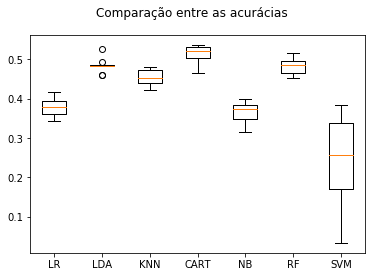

In [22]:
# Visualização das acurácias dos diferentes modelos.
fig = pyplot.figure()
fig.suptitle('Comparação entre as acurácias')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [23]:
# Padronização do dataset, utilizando StandardScaler
# Aplica normalização por z-score
pipelines = []
pipelines.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='liblinear'))])))
pipelines.append(('LDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier(n_jobs=-1))])))
pipelines.append(('CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier(max_depth=2, 
                                                                                             random_state=0, 
                                                                                             n_jobs=-1))])))
pipelines.append(('SVM', Pipeline([('Scaler', StandardScaler()),('SVM', LinearSVC())])))
results = []
names = []
for name, model in pipelines:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.454299 (0.022459)
LDA: 0.484272 (0.017267)
KNN: 0.475389 (0.014937)
CART: 0.514062 (0.019094)
NB: 0.460580 (0.020430)
RF: 0.482972 (0.020124)
SVM: 0.437828 (0.021006)


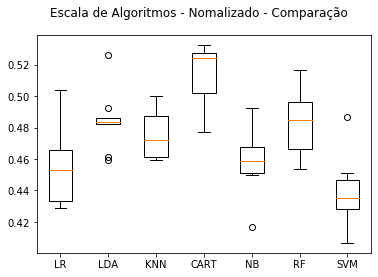

In [24]:
# Visualização das acurácias dos diferentes modelos pós-normalização do dataset.
fig = pyplot.figure()
fig.suptitle('Escala de Algoritmos - Nomalizado - Comparação')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [25]:
# Ajuste de parâmetros do modelo KNN. Tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13]
param_grid = dict(n_neighbors=neighbors)

model = KNeighborsClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

#grid_result = grid.fit(rescaledX, y_train)
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.483894 using {'n_neighbors': 1}
0.483894 (0.024943) with: {'n_neighbors': 1}
0.476128 (0.029309) with: {'n_neighbors': 2}
0.465574 (0.029610) with: {'n_neighbors': 3}
0.456506 (0.024676) with: {'n_neighbors': 4}
0.454285 (0.019182) with: {'n_neighbors': 5}
0.458177 (0.014813) with: {'n_neighbors': 6}
0.453183 (0.015254) with: {'n_neighbors': 7}
0.446703 (0.021079) with: {'n_neighbors': 8}
0.452434 (0.018314) with: {'n_neighbors': 9}
0.453730 (0.017169) with: {'n_neighbors': 10}
0.449292 (0.015974) with: {'n_neighbors': 11}
0.447621 (0.020377) with: {'n_neighbors': 12}
0.442813 (0.016219) with: {'n_neighbors': 13}


In [26]:
# Ajuste de parâmetros do modelo CART. Tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
max_features = ['auto', 'sqrt', 'log2']

param_grid = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, max_features=max_features)

model = DecisionTreeClassifier()

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.378237 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'auto', 'splitter': 'best'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'auto', 'splitter': 'best'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'auto', 'splitter': 'random'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'sqrt', 'splitter': 'best'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'sqrt', 'splitter': 'random'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'log2', 'splitter': 'best'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'log2', 'splitter': 'random'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.2, 'max_features': 'auto', 'splitter': 'best'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.2, 'max_features': 'auto', 'splitter': 'random'}


In [27]:
# Ajuste de parâmetros do modelo RF - Random Forest. Tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

criterion = ['gini', 'entropy']
max_depth = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
max_features = [None, 'sqrt', 'log2']

param_grid = dict(criterion=criterion, max_depth=max_depth, max_features=max_features)

model = RandomForestClassifier(n_jobs=-1)

kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)

grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.378237 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': None}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': None}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'sqrt'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'log2'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.2, 'max_features': None}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.2, 'max_features': 'sqrt'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.2, 'max_features': 'log2'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.25, 'max_features': None}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.25, 'max_features': 'sqrt'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.25, 'max_features': 'log2'}
0.378237 (0.021940) with: {'criterion': 'gini', 'max_depth': 0.3, 'max_features': None}
0.378237 (0.021940

### Gera nova amostragem com 30% do dataset

In [28]:
from sklearn.model_selection import train_test_split

X, y = dataset[features], dataset['faixa_renda_bruta']
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.3, ## -> 30% será usado para treinar e avaliar
                      random_state=42,
                      stratify=y)

X = X_test
y = y_test

del X_train, y_train, X_test, y_test

print (X.shape, y.shape)

(172838, 6) (172838,)


In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      #test_size=0.15, # 15% de 522.549 será usado para avaliar
                      test_size=0.3, # 30% de 522.549 será usado para avaliar
                      random_state=42, 
                      stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(120986, 6) (120986,)
(51852, 6) (51852,)


In [30]:
# Encoding, com 2 = M, 1 = F, 0 = ?.
#Transformando campos tipo object em campos numéricos para aplicação dos modelos de classificação
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X_train
le = le.fit(X_train['ic_sexo'])
X_train['ic_sexo'] = le.transform(X_train['ic_sexo'])

# aplica no X_test
le = le.fit(X_test['ic_sexo'])
X_test['ic_sexo'] = le.transform(X_test['ic_sexo'])

#X_train.ic_sexo.value_counts()

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# Execução do modelo KNN sobre a amostra
Após as avaliações de desempenho comparativos dos modelos, foi selecionado o algorítmo de classificação KNN dado que este apresentou os melhores resultados. Segue abaixo a execução deste modelo sobre todo o conjunto de dados, gerando a matriz de confusão e demais métricas de avaliação.  

In [31]:
# Modelo final KNN - Best: 0.883590 using {'n_neighbors': 1}
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)

model_KNN = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)

#model_KNN.fit(rescaledX, y_train)
model_KNN.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
#rescaledValidationX = scaler.transform(X_test)

#predictions = model_KNN.predict(rescaledValidationX)
predictions = model_KNN.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.6590295456298696
[[10920  2293   346   169   105    54    35]
 [ 2287 15015  1563   387   202    95    60]
 [  383  1586  3531  1267   379   114    42]
 [  152   403  1257  2482   816   148    60]
 [  133   244   432   818  1500   279    90]
 [   58   143   129   157   326   473   150]
 [   51    83    60    47   114   163   251]]
              precision    recall  f1-score   support

           1       0.78      0.78      0.78     13922
           2       0.76      0.77      0.76     19609
           3       0.48      0.48      0.48      7302
           4       0.47      0.47      0.47      5318
           5       0.44      0.43      0.43      3496
           6       0.36      0.33      0.34      1436
           7       0.36      0.33      0.34       769

    accuracy                           0.66     51852
   macro avg       0.52      0.51      0.52     51852
weighted avg       0.66      0.66      0.66     51852



# Execução do modelo KNN sobre todo o conjunto de dados
Observou-se uma forte capacidade de generalização do modelo, este apresentando resultados ainda melhores quando aplicado sobre o dataset completo.

In [32]:
# Ler o arquivo
dataset = pd.read_csv("/home/marcello/Documentos/git/ibge-indicadores-censitarios/dados/notebook/pre_processing_cliente_renda_ibge/pre_processing_cliente_renda_ibge.csv", sep=';')
dataset.shape

(1741828, 23)

In [33]:
# conjunto de dados SEM renda
# será usado para inferir/estimar a faixa de renda
dataset_sem_renda = dataset[dataset['vr_renda_bruta'] == 0]

# conjunto de dados COM renda
# será usando para treinar os modelos a inferir/estimar a renda
dataset = dataset[dataset['vr_renda_bruta'] != 0]

In [34]:
dataset_sem_renda.shape

(1165703, 23)

### Com renda

In [35]:
X, y = dataset[features], dataset['faixa_renda_bruta']
X.shape

(576125, 6)

### Sem renda

In [36]:
X_sem_renda, y_sem_renda = dataset_sem_renda[features], dataset_sem_renda['faixa_renda_bruta']
X_sem_renda.shape

(1165703, 6)

In [37]:
# Encoding, com 2 = M, 1 = F, 0 = ?.
#Transformando campos tipo object em campos numéricos para aplicação dos modelos de classificação
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X['ic_sexo']
le = le.fit(X['ic_sexo'])
X['ic_sexo'] = le.transform(X['ic_sexo'])

# aplica no X_sem_renda['ic_sexo']
le = le.fit(X_sem_renda['ic_sexo'])
X_sem_renda['ic_sexo'] = le.transform(X_sem_renda['ic_sexo'])

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [38]:
# Quantidade de clientes por faixas COM renda
y.value_counts()

2    217878
1    154691
3     81131
4     59088
5     38843
6     15952
7      8542
Name: faixa_renda_bruta, dtype: int64

In [39]:
# Quantidade de clientes por faixas SEM renda
y_sem_renda.value_counts()

0    1165703
Name: faixa_renda_bruta, dtype: int64

Estima faixa de renda IBGE no conjunto que possui alguma renda no SICLI

In [40]:
faixa_renda_estimada = model_KNN.predict(X)

print(accuracy_score(y, faixa_renda_estimada))
print(confusion_matrix(y, faixa_renda_estimada))
print(classification_report(y, faixa_renda_estimada))
                            
dataset['faixa_renda_estimada'] = faixa_renda_estimada
dataset[features_comparar]

0.7240911260577132
[[127481  21209   2952   1401    893    446    309]
 [ 20581 176319  14305   3436   1784    916    537]
 [  3046  14484  46990  11764   3633    860    354]
 [  1531   3514  11345  33768   7204   1257    469]
 [  1030   2039   3738   7423  21440   2412    761]
 [   528   1248   1093   1385   2899   7362   1437]
 [   367    746    496    554   1023   1549   3807]]
              precision    recall  f1-score   support

           1       0.82      0.82      0.82    154691
           2       0.80      0.81      0.81    217878
           3       0.58      0.58      0.58     81131
           4       0.57      0.57      0.57     59088
           5       0.55      0.55      0.55     38843
           6       0.50      0.46      0.48     15952
           7       0.50      0.45      0.47      8542

    accuracy                           0.72    576125
   macro avg       0.62      0.61      0.61    576125
weighted avg       0.72      0.72      0.72    576125



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
8,1,50,F,3127701005013,1.74,35.34,1,201602,880.0,2587.68,1723.23,3,2
9,1,37,M,3168606003006,1.31,41.77,1,202007,1045.0,600.00,600.00,1,1
11,2,51,F,3136702005003,1.50,39.79,2,200510,300.0,520.00,500.00,2,3
15,5,84,F,3147907003001,4.69,33.11,5,200502,260.0,260.00,260.00,1,1
21,1,37,F,3106200005045,1.25,27.63,1,201611,880.0,1112.80,1112.80,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741807,1,29,F,3170701003006,2.05,36.85,1,201603,880.0,980.00,980.00,2,2
1741811,1,33,M,3143302005020,1.81,28.40,1,201608,880.0,1300.00,1300.00,2,2
1741812,6,68,M,3106200005014,0.09,39.69,6,200503,260.0,329.25,327.10,2,2
1741813,1,31,F,3122306005003,2.29,28.52,1,200609,350.0,350.00,350.00,1,1


- Para provar que o modelo KNN original (acima) está adequado, foram aplicadas duas técnicas de otimização por Resampling. O intuito é identificar a possibilidade de melhoria e se de fato o modelo está generalizando e produzindo os melhores resultados.

- Após aplicar as técnicas de resampling (abaixo) foi constatado que o modelo KNN original de fato produziu os melhores resultados, pois após comparar as métricas `precision`, `recall` e `f1-score` constatou-se que o modelo KNN original **sem resampling** melhorou os scores aṕos ser aplicado sobre todo o conjunto de dados.


Estima faixa de renda IBGE no conjunto **SEM renda** no SICLI

In [41]:
faixa_renda_estimada = model_KNN.predict(X_sem_renda)

print(accuracy_score(y_sem_renda, faixa_renda_estimada))
print(confusion_matrix(y_sem_renda, faixa_renda_estimada))
print(classification_report(y_sem_renda, faixa_renda_estimada))
                            
dataset_sem_renda['faixa_renda_estimada'] = faixa_renda_estimada
dataset_sem_renda[features_comparar]

0.0
[[     0 132459 277472 145780 155704 190186 147435 116667]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]


/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00 1165703.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0

    accuracy                           0.00 1165703.0
   macro avg       0.00      0.00      0.00 1165703.0
weighted avg       0.00      0.00      0.00 1165703.0



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
0,7,41,M,3167202005001,1.79,2.63,7,202007,1045.0,0.0,0.0,0,1
1,5,72,F,3118403001001,8.06,8.44,5,202007,1045.0,0.0,0.0,0,3
2,0,33,F,3163706003002,2.11,3.85,0,202007,1045.0,0.0,0.0,0,2
3,1,20,M,3156452001001,1.44,6.06,1,201709,937.0,0.0,0.0,0,2
4,1,24,M,3159902001001,2.00,1.46,1,201404,724.0,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741823,9,75,M,3106200005044,8.68,11.19,9,200607,350.0,0.0,1000.0,0,4
1741824,0,44,F,3142908001001,1.90,19.78,0,202007,1045.0,0.0,0.0,0,2
1741825,0,52,M,3154606005019,1.09,1.02,0,202007,1045.0,0.0,0.0,0,3
1741826,1,49,F,3111309001001,1.48,2.52,1,200409,260.0,0.0,800.0,0,1


## Otimização por Resampling

Técnicas de resampling podem ser utilizadas quando existe um desbalanço entre classes. No caso da classe faixa de renda, existem muito mais registros da classe 0 do que das classes 6 e 7. Para compensar esta disparidade no dataset de forma a não prejudicar o modelo, podem ser utilizadas técnicas de resampling. Abaixo foi utilizado undersampling por Tomek Links e Neighborhood Cleaning Rows. 
Referência: https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/

In [42]:
from sklearn.model_selection import train_test_split

X, y = dataset[features], dataset['faixa_renda_bruta']
X_train, X_test, y_train, y_test =\
     train_test_split(X, y,
                      test_size=0.3, ## -> 30% será usado para treinar e avaliar o modelo KNN
                      random_state=42,
                      stratify=y)

X = X_test
y = y_test

del X_train, y_train, X_test, y_test

print (X.shape, y.shape)

(172838, 6) (172838,)


In [43]:
#encoding, com 2 = M, 1 = F, 0 = ?
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X_train
le = le.fit(X['ic_sexo'])
X['ic_sexo'] = le.transform(X['ic_sexo'])

X.ic_sexo.value_counts()

2    95063
1    77419
0      356
Name: ic_sexo, dtype: int64

## Aplica undersampling usando heurística TomekLinks
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_illustration_tomek_links.html

In [44]:
from imblearn.under_sampling import TomekLinks
undersample = TomekLinks(n_jobs=-1)
X_train_tml, y_train_tml = undersample.fit_resample(X, y)

X_train_tml.shape

(150014, 6)

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
     train_test_split(X_train_tml, y_train_tml,
                      test_size=0.3, # 30% de 518.834 será usado para avaliar o modelo
                      random_state=42, 
                      stratify=y_train_tml)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(105009, 6) (105009,)
(45005, 6) (45005,)


In [46]:
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)

model_KNN_tml = KNeighborsClassifier(n_neighbors=1)

#model_KNN_tml.fit(rescaledX, y_train)
model_KNN_tml.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
#rescaledValidationX = scaler.transform(X_test)

#predictions = model_KNN_tml.predict(rescaledValidationX)
predictions = model_KNN_tml.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7422730807688035
[[10793  1576   201   106    67    18    28]
 [ 1558 14825  1108   232   110    57    51]
 [  225  1177  3424   726   222    46    37]
 [  104   253   839  2258   459    79    52]
 [   48   151   271   523  1378   152    79]
 [   25    90    72    89   193   424   110]
 [   30    71    47    60   111   146   304]]
              precision    recall  f1-score   support

           1       0.84      0.84      0.84     12789
           2       0.82      0.83      0.82     17941
           3       0.57      0.58      0.58      5857
           4       0.57      0.56      0.56      4044
           5       0.54      0.53      0.54      2602
           6       0.46      0.42      0.44      1003
           7       0.46      0.40      0.43       769

    accuracy                           0.74     45005
   macro avg       0.61      0.59      0.60     45005
weighted avg       0.74      0.74      0.74     45005



## Estimar faixa de renda sobre todo o conjunto de dados  
- Utilizado o dataset sobre o qual foi aplicado undersampling por Tomek Links

In [47]:
X, y = dataset[features], dataset['faixa_renda_bruta']

In [48]:
#encoding, com 2 = M, 1 = F, 0 = ?
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X['ic_sexo']
le = le.fit(X['ic_sexo'])
X['ic_sexo'] = le.transform(X['ic_sexo'])

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [49]:
faixa_renda_estimada = model_KNN_tml.predict(X)

print(accuracy_score(y, faixa_renda_estimada))
print(confusion_matrix(y, faixa_renda_estimada))
print(classification_report(y, faixa_renda_estimada))

dataset['faixa_renda_estimada'] = faixa_renda_estimada
dataset[features_comparar]

0.7135986114124538
[[128874  19465   2813   1542   1034    469    494]
 [ 22570 176371  12084   3042   1905    928    978]
 [  3405  16051  45237  10909   3892    880    757]
 [  1883   4102  13145  30879   6944   1247    888]
 [  1029   2235   4618   8014  19366   2197   1384]
 [   486   1320   1215   1603   2951   6127   2250]
 [   297    664    452    553    947   1361   4268]]
              precision    recall  f1-score   support

           1       0.81      0.83      0.82    154691
           2       0.80      0.81      0.81    217878
           3       0.57      0.56      0.56     81131
           4       0.55      0.52      0.53     59088
           5       0.52      0.50      0.51     38843
           6       0.46      0.38      0.42     15952
           7       0.39      0.50      0.44      8542

    accuracy                           0.71    576125
   macro avg       0.59      0.59      0.58    576125
weighted avg       0.71      0.71      0.71    576125



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
8,1,50,F,3127701005013,1.74,35.34,1,201602,880.0,2587.68,1723.23,3,2
9,1,37,M,3168606003006,1.31,41.77,1,202007,1045.0,600.00,600.00,1,1
11,2,51,F,3136702005003,1.50,39.79,2,200510,300.0,520.00,500.00,2,2
15,5,84,F,3147907003001,4.69,33.11,5,200502,260.0,260.00,260.00,1,1
21,1,37,F,3106200005045,1.25,27.63,1,201611,880.0,1112.80,1112.80,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741807,1,29,F,3170701003006,2.05,36.85,1,201603,880.0,980.00,980.00,2,2
1741811,1,33,M,3143302005020,1.81,28.40,1,201608,880.0,1300.00,1300.00,2,2
1741812,6,68,M,3106200005014,0.09,39.69,6,200503,260.0,329.25,327.10,2,2
1741813,1,31,F,3122306005003,2.29,28.52,1,200609,350.0,350.00,350.00,1,2


**sem renda**

In [50]:
faixa_renda_estimada = model_KNN_tml.predict(X_sem_renda)

print(accuracy_score(y_sem_renda, faixa_renda_estimada))
print(confusion_matrix(y_sem_renda, faixa_renda_estimada))
print(classification_report(y_sem_renda, faixa_renda_estimada))

dataset_sem_renda['faixa_renda_estimada'] = faixa_renda_estimada
dataset_sem_renda[features_comparar]

0.0
[[     0 109435 272836 143268 151127 189744 136068 163225]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]


/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00 1165703.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0

    accuracy                           0.00 1165703.0
   macro avg       0.00      0.00      0.00 1165703.0
weighted avg       0.00      0.00      0.00 1165703.0



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
0,7,41,M,3167202005001,1.79,2.63,7,202007,1045.0,0.0,0.0,0,1
1,5,72,F,3118403001001,8.06,8.44,5,202007,1045.0,0.0,0.0,0,3
2,0,33,F,3163706003002,2.11,3.85,0,202007,1045.0,0.0,0.0,0,7
3,1,20,M,3156452001001,1.44,6.06,1,201709,937.0,0.0,0.0,0,2
4,1,24,M,3159902001001,2.00,1.46,1,201404,724.0,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741823,9,75,M,3106200005044,8.68,11.19,9,200607,350.0,0.0,1000.0,0,4
1741824,0,44,F,3142908001001,1.90,19.78,0,202007,1045.0,0.0,0.0,0,2
1741825,0,52,M,3154606005019,1.09,1.02,0,202007,1045.0,0.0,0.0,0,2
1741826,1,49,F,3111309001001,1.48,2.52,1,200409,260.0,0.0,800.0,0,1


## Aplica undersampling usando heurística NeighbourhoodCleaningRule  
- https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NeighbourhoodCleaningRule.html  

In [51]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule(n_jobs=-1)
X_train_ncr, y_train_ncr = ncr.fit_resample(X,y)

X_train_ncr.shape

(439640, 6)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
     train_test_split(X_train_ncr, y_train_ncr,
                      #test_size=0.15, # 15% de 507.854 será usado para avaliar o modelo eleito
                      test_size=0.30, # 30% de 507.854 será usado para avaliar o modelo eleito
                      random_state=42, 
                      stratify=y_train_ncr)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(307748, 6) (307748,)
(131892, 6) (131892,)


In [53]:
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)

model_KNN_ncr = KNeighborsClassifier(n_neighbors=1)

#model_KNN_ncr.fit(rescaledX, y_train)
model_KNN_ncr.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
#rescaledValidationX = scaler.transform(X_test)

#predictions = model_KNN_ncr.predict(rescaledValidationX)
predictions = model_KNN_ncr.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9534012677038789
[[40805   645    72    55    32    13    65]
 [  736 54508   174    48    62    23   137]
 [   89   280 13664   455   115    14    62]
 [   50    68   558  8662   221    15    76]
 [   42    49   128   270  5234    39   126]
 [    6    27    24    25    48  1403   204]
 [   83   222   100   126   251   311  1470]]
              precision    recall  f1-score   support

           1       0.98      0.98      0.98     41687
           2       0.98      0.98      0.98     55688
           3       0.93      0.93      0.93     14679
           4       0.90      0.90      0.90      9650
           5       0.88      0.89      0.88      5888
           6       0.77      0.81      0.79      1737
           7       0.69      0.57      0.63      2563

    accuracy                           0.95    131892
   macro avg       0.87      0.87      0.87    131892
weighted avg       0.95      0.95      0.95    131892



## Estimar faixa de renda sobre todo o conjunto de dados
- Utilizado o dataset sobre o qual foi aplicado undersampling por NeighbourhoodCleaningRule

In [54]:
X, y = dataset[features], dataset['faixa_renda_bruta']

In [55]:
#encoding, com 2 = M, 1 = F, 0 = ?
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X['ic_sexo']
le = le.fit(X['ic_sexo'])
X['ic_sexo'] = le.transform(X['ic_sexo'])

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [56]:
faixa_renda_estimada = model_KNN_ncr.predict(X)

print(accuracy_score(y, faixa_renda_estimada))
print(confusion_matrix(y, faixa_renda_estimada))
print(classification_report(y, faixa_renda_estimada))

dataset['faixa_renda_estimada'] = faixa_renda_estimada
dataset[features_comparar]

0.795332610110653
[[142875   9084    845    610    438    199    640]
 [ 20867 190310   3489    861    873    340   1138]
 [  3409  17449  52854   5093   1199    257    870]
 [  1702   4288  12279  36183   3183    303   1150]
 [  1017   1953   4564   6863  22157    661   1628]
 [   454   1285   1053   1358   2473   6436   2893]
 [    84    233    102    130    259    338   7396]]
              precision    recall  f1-score   support

           1       0.84      0.92      0.88    154691
           2       0.85      0.87      0.86    217878
           3       0.70      0.65      0.68     81131
           4       0.71      0.61      0.66     59088
           5       0.72      0.57      0.64     38843
           6       0.75      0.40      0.53     15952
           7       0.47      0.87      0.61      8542

    accuracy                           0.80    576125
   macro avg       0.72      0.70      0.69    576125
weighted avg       0.79      0.80      0.79    576125



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
8,1,50,F,3127701005013,1.74,35.34,1,201602,880.0,2587.68,1723.23,3,2
9,1,37,M,3168606003006,1.31,41.77,1,202007,1045.0,600.00,600.00,1,1
11,2,51,F,3136702005003,1.50,39.79,2,200510,300.0,520.00,500.00,2,2
15,5,84,F,3147907003001,4.69,33.11,5,200502,260.0,260.00,260.00,1,1
21,1,37,F,3106200005045,1.25,27.63,1,201611,880.0,1112.80,1112.80,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741807,1,29,F,3170701003006,2.05,36.85,1,201603,880.0,980.00,980.00,2,2
1741811,1,33,M,3143302005020,1.81,28.40,1,201608,880.0,1300.00,1300.00,2,3
1741812,6,68,M,3106200005014,0.09,39.69,6,200503,260.0,329.25,327.10,2,2
1741813,1,31,F,3122306005003,2.29,28.52,1,200609,350.0,350.00,350.00,1,1


**sem renda**

In [57]:
faixa_renda_estimada = model_KNN_ncr.predict(X_sem_renda)

print(accuracy_score(y_sem_renda, faixa_renda_estimada))
print(confusion_matrix(y_sem_renda, faixa_renda_estimada))
print(classification_report(y_sem_renda, faixa_renda_estimada))

dataset_sem_renda['faixa_renda_estimada'] = faixa_renda_estimada
dataset_sem_renda[features_comparar]

0.0
[[     0 122255 304474 127754 119874 154239  80055 257052]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]


/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00 1165703.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0

    accuracy                           0.00 1165703.0
   macro avg       0.00      0.00      0.00 1165703.0
weighted avg       0.00      0.00      0.00 1165703.0



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
0,7,41,M,3167202005001,1.79,2.63,7,202007,1045.0,0.0,0.0,0,4
1,5,72,F,3118403001001,8.06,8.44,5,202007,1045.0,0.0,0.0,0,4
2,0,33,F,3163706003002,2.11,3.85,0,202007,1045.0,0.0,0.0,0,2
3,1,20,M,3156452001001,1.44,6.06,1,201709,937.0,0.0,0.0,0,2
4,1,24,M,3159902001001,2.00,1.46,1,201404,724.0,0.0,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741823,9,75,M,3106200005044,8.68,11.19,9,200607,350.0,0.0,1000.0,0,3
1741824,0,44,F,3142908001001,1.90,19.78,0,202007,1045.0,0.0,0.0,0,2
1741825,0,52,M,3154606005019,1.09,1.02,0,202007,1045.0,0.0,0.0,0,7
1741826,1,49,F,3111309001001,1.48,2.52,1,200409,260.0,0.0,800.0,0,5


### Aplica under e over sampling usando heurística SMOTETomek
- https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html#imblearn.combine.SMOTETomek

In [58]:
from imblearn.combine import SMOTETomek

stn = SMOTETomek(n_jobs=-1)
X_train_stn, y_train_stn = stn.fit_resample(X,y)

X_train_stn.shape

(1487884, 6)

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
     train_test_split(X_train_stn, y_train_stn,
                      #test_size=0.15, # 15% de 507.854 será usado para avaliar o modelo eleito
                      test_size=0.30, # 30% de 507.854 será usado para avaliar o modelo eleito
                      random_state=42, 
                      stratify=y_train_stn)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1041518, 6) (1041518,)
(446366, 6) (446366,)


In [60]:
model_KNN_stn = KNeighborsClassifier(n_neighbors=1)

model_KNN_stn.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
#rescaledValidationX = scaler.transform(X_test)

predictions = model_KNN_stn.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8709735956591675
[[56698  5279   802   415   292   238   167]
 [ 5921 48288  6124  1261   481   442   317]
 [  918  6851 49764  4117   950   423   274]
 [  323  1429  4121 54131  2810   543   294]
 [  226   354   885  2958 57590  1502   509]
 [  106   182   268   476  1545 60172  1425]
 [   64   128   122   211   415  1425 62130]]
              precision    recall  f1-score   support

           1       0.88      0.89      0.88     63891
           2       0.77      0.77      0.77     62834
           3       0.80      0.79      0.79     63297
           4       0.85      0.85      0.85     63651
           5       0.90      0.90      0.90     64024
           6       0.93      0.94      0.93     64174
           7       0.95      0.96      0.96     64495

    accuracy                           0.87    446366
   macro avg       0.87      0.87      0.87    446366
weighted avg       0.87      0.87      0.87    446366



## Estimar faixa de renda sobre todo o conjunto de dados
- Utilizado o dataset sobre o qual foi aplicado under e over sampling usando heurística SMOTEENN

In [61]:
X, y = dataset[features], dataset['faixa_renda_bruta']

In [62]:
#encoding, com 2 = M, 1 = F, 0 = ?
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# aplica no X['ic_sexo']
le = le.fit(X['ic_sexo'])
X['ic_sexo'] = le.transform(X['ic_sexo'])

/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [63]:
faixa_renda_estimada = model_KNN_stn.predict(X)

print(accuracy_score(y, faixa_renda_estimada))
print(confusion_matrix(y, faixa_renda_estimada))
print(classification_report(y, faixa_renda_estimada))

dataset['faixa_renda_estimada'] = faixa_renda_estimada
dataset[features_comparar]

0.8821245389455413
[[143235   8760   1237    571    399    300    189]
 [ 13366 187429  12639   2483    826    683    452]
 [   987   8485  67006   3495    716    275    167]
 [   232   1486   3287  51959   1711    286    127]
 [   105    250    515   1704  35542    576    151]
 [    35     78     73    127    536  14903    200]
 [    14     43     29     47     80    189   8140]]
              precision    recall  f1-score   support

           1       0.91      0.93      0.92    154691
           2       0.91      0.86      0.88    217878
           3       0.79      0.83      0.81     81131
           4       0.86      0.88      0.87     59088
           5       0.89      0.92      0.90     38843
           6       0.87      0.93      0.90     15952
           7       0.86      0.95      0.91      8542

    accuracy                           0.88    576125
   macro avg       0.87      0.90      0.88    576125
weighted avg       0.88      0.88      0.88    576125



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
8,1,50,F,3127701005013,1.74,35.34,1,201602,880.0,2587.68,1723.23,3,3
9,1,37,M,3168606003006,1.31,41.77,1,202007,1045.0,600.00,600.00,1,1
11,2,51,F,3136702005003,1.50,39.79,2,200510,300.0,520.00,500.00,2,2
15,5,84,F,3147907003001,4.69,33.11,5,200502,260.0,260.00,260.00,1,1
21,1,37,F,3106200005045,1.25,27.63,1,201611,880.0,1112.80,1112.80,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741807,1,29,F,3170701003006,2.05,36.85,1,201603,880.0,980.00,980.00,2,2
1741811,1,33,M,3143302005020,1.81,28.40,1,201608,880.0,1300.00,1300.00,2,2
1741812,6,68,M,3106200005014,0.09,39.69,6,200503,260.0,329.25,327.10,2,2
1741813,1,31,F,3122306005003,2.29,28.52,1,200609,350.0,350.00,350.00,1,1


#### sem renda

In [64]:
faixa_renda_estimada = model_KNN_stn.predict(X_sem_renda)

print(accuracy_score(y_sem_renda, faixa_renda_estimada))
print(confusion_matrix(y_sem_renda, faixa_renda_estimada))
print(classification_report(y_sem_renda, faixa_renda_estimada))

dataset_sem_renda['faixa_renda_estimada'] = faixa_renda_estimada
dataset_sem_renda[features_comparar]

0.0
[[     0 114498 204112 128145 139466 183320 207627 188535]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0      0]]


/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marcello/anaconda3/envs/av/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00 1165703.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
           7       0.00      0.00      0.00       0.0

    accuracy                           0.00 1165703.0
   macro avg       0.00      0.00      0.00 1165703.0
weighted avg       0.00      0.00      0.00 1165703.0



,nu_estdo_civil_p27,idade,ic_sexo,co_area_ponderacao,pc_idade_area_ponderacao,pc_total_pessoa_area_ponderacao_liquida,nu_estdo_civil_p27,dt_apuracao_renda,vr_salario_minimo,vr_renda_bruta,vr_renda_liquida,faixa_renda_bruta,faixa_renda_estimada
0,7,41,M,3167202005001,1.79,2.63,7,202007,1045.0,0.0,0.0,0,3
1,5,72,F,3118403001001,8.06,8.44,5,202007,1045.0,0.0,0.0,0,3
2,0,33,F,3163706003002,2.11,3.85,0,202007,1045.0,0.0,0.0,0,2
3,1,20,M,3156452001001,1.44,6.06,1,201709,937.0,0.0,0.0,0,4
4,1,24,M,3159902001001,2.00,1.46,1,201404,724.0,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741823,9,75,M,3106200005044,8.68,11.19,9,200607,350.0,0.0,1000.0,0,3
1741824,0,44,F,3142908001001,1.90,19.78,0,202007,1045.0,0.0,0.0,0,2
1741825,0,52,M,3154606005019,1.09,1.02,0,202007,1045.0,0.0,0.0,0,5
1741826,1,49,F,3111309001001,1.48,2.52,1,200409,260.0,0.0,800.0,0,5


In [65]:
stop

NameError: name 'stop' is not defined

Foi verificada uma leve perda de precisão aplicadas as técnicas de resampling, desta forma será utilizado o modelo sem a utilização destas técnicas

## Abaixo segue análise dos modelos descartados CART e Random Forest

In [ ]:
# Modelo final - Decision Tree CART 
# Best: 0.604027 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': 'auto', 'splitter': 'best'}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

model_DT = DecisionTreeClassifier(criterion='gini', 
                                  max_depth=0.15, 
                                  max_features='auto', 
                                  splitter='best')
#model_DT.fit(rescaledX, y_train)
model_DT.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)

#predictions = model_DT.predict(rescaledValidationX)
predictions = model_DT.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
# Modelo final RandomFlorest
# Best: 0.604027 using {'criterion': 'gini', 'max_depth': 0.15, 'max_features': None}
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

model_RF =  RandomForestClassifier(criterion='gini', 
                                   max_depth=0.15, 
                                   max_features=None, 
                                   random_state=42, 
                                   n_jobs=-1)

model_RF.fit(rescaledX, y_train)
#model_RF.fit(X_train, y_train)

# Estima a acurácia no dataset de validação
rescaledValidationX = scaler.transform(X_test)

predictions = model_RF.predict(rescaledValidationX)
#predictions = model_RF.predict(X_test)

print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))